In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

In [2]:
tickers_df = pd.read_excel('/Users/henrywzh/Documents/data/恒生指数.xlsx')
tickers = [str(t) for t in tickers_df['证券代码'].values.tolist()]
tickers = [t[1:] for t in tickers if t[-3:] == '.HK']
print(tickers)

df = yf.download(tickers, start='2023-08-01', end='2024-08-06', interval='1h')

['0001.HK', '0002.HK', '0003.HK', '0005.HK', '0006.HK', '0011.HK', '0012.HK', '0016.HK', '0017.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK', '0322.HK', '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK', '0992.HK', '1038.HK', '1044.HK', '1088.HK', '1093.HK', '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK', '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK', '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9961.HK', '9988.HK', '9999.HK']


[*********************100%%**********************]  82 of 82 completed


In [3]:
dollar_volume_df = df['Volume'] * ((df['Close'] + df['Open']) / 2)
dollar_volumes = dollar_volume_df.sum(axis=1)
dollar_volumes.name = 'dollar_vol'
avg_dollar_vol_in_a_day = dollar_volumes.groupby(dollar_volumes.index.hour).mean()
dollar_volumes = pd.DataFrame(dollar_volumes)
dollar_volumes['date_str'] = [f'{i.year}-{i.month}-{i.day}' for i in dollar_volumes.index]

In [4]:
day_vol_df = pd.DataFrame(dollar_volumes.resample('D').sum()).rename(columns={'dollar_vol': 'day_dollar_vol'})
day_vol_df['date_str'] = [f'{i.year}-{i.month}-{i.day}' for i in day_vol_df.index]

In [5]:
dollar_vol_df = pd.merge(dollar_volumes, day_vol_df, on='date_str').set_index(dollar_volumes.index)

Task: Find the first-two hours dollar volume coefficient (x)
x * first_two_hours_dollar_volume = daily_dollar_volume

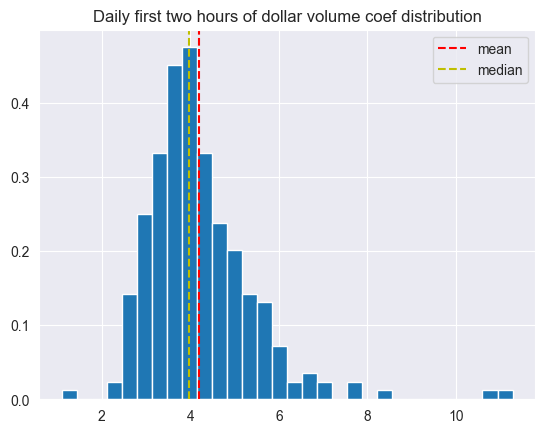

Mean coef: 4.1895352021616965, Std: 1.2173837184082308
Skewness: 1.851154054538862, Kurtosis: 7.401182811987
Jarque-Bera test p-value: 2.3117006141230713e-148
p_value < 0.05, the distribution is likely not normal


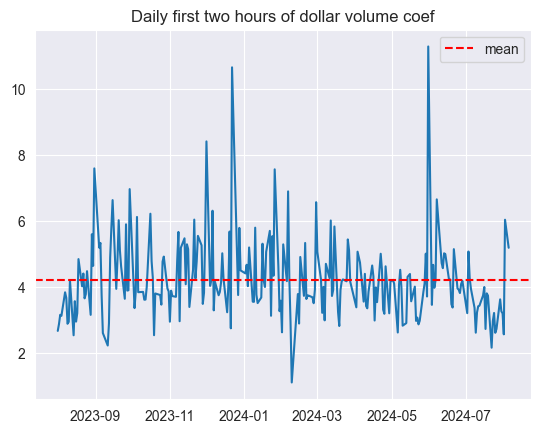

Dickey-Fuller test p-value: 3.290188367194937e-15
p_value < 0.05, the data is likely to be stationary


In [6]:
two_hour_df = dollar_vol_df[['dollar_vol', 'day_dollar_vol']][dollar_vol_df.index.hour < 11].resample('D').sum()
x = (two_hour_df['day_dollar_vol'] / two_hour_df['dollar_vol'] / 2).dropna()
plt.hist(x, bins=30, density=True)
plt.axvline(x = x.mean(), color='r', linestyle='--', label='mean')
plt.axvline(x = x.median(), color='y', linestyle='--', label='median')
plt.title('Daily first two hours of dollar volume coef distribution')
plt.legend()
plt.show()

print(f'Mean coef: {x.mean()}, Std: {x.std()}')
print(f'Skewness: {x.skew()}, Kurtosis: {x.kurtosis()}')
test_stats, p_value = stats.jarque_bera(x)
print(f'Jarque-Bera test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the distribution is likely not normal')
else:
    print('p_value >= 0.05, the distribution is likely to be normal')
    
plt.title('Daily first two hours of dollar volume coef')
plt.plot(x)
plt.axhline(x.mean(), label='mean', color='r', linestyle='--')
plt.legend()
plt.show()

tup = adfuller(x)
test_stats, p_value = tup[0], tup[1]
print(f'Dickey-Fuller test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the data is likely to be stationary')
else:
    print('p_value >= 0.05, the data is likely to be non-stationary')

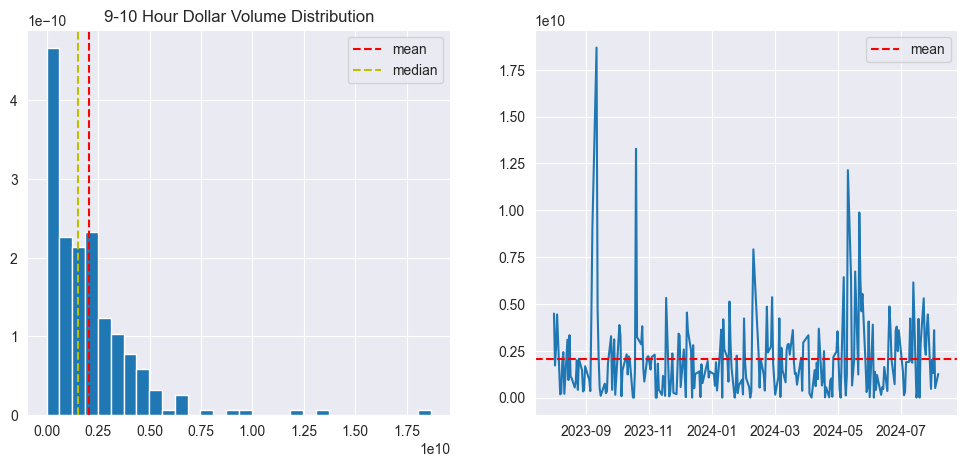

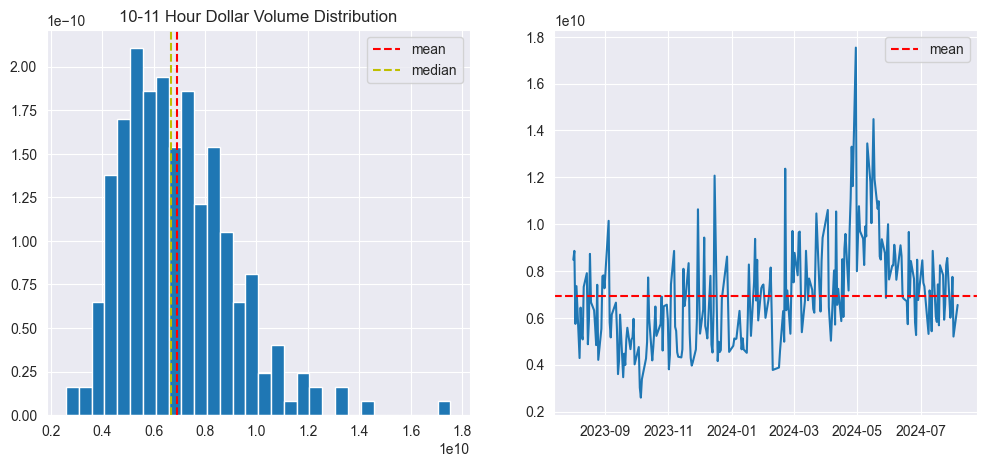

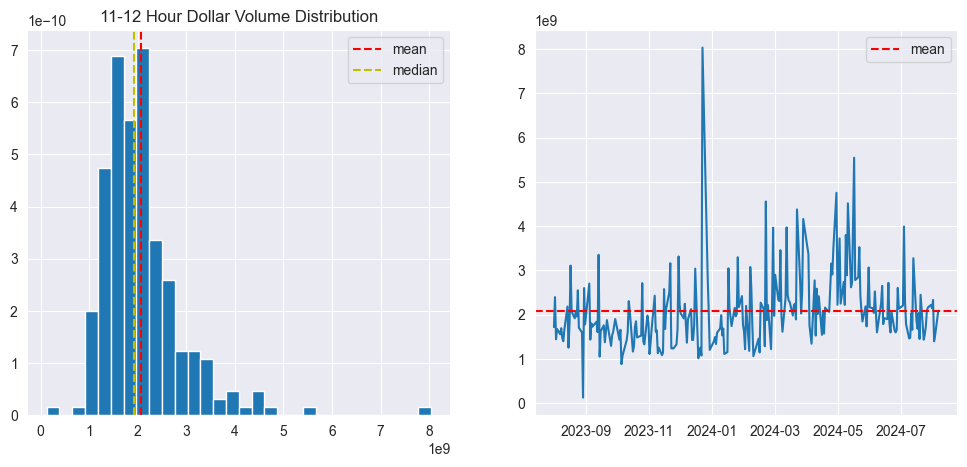

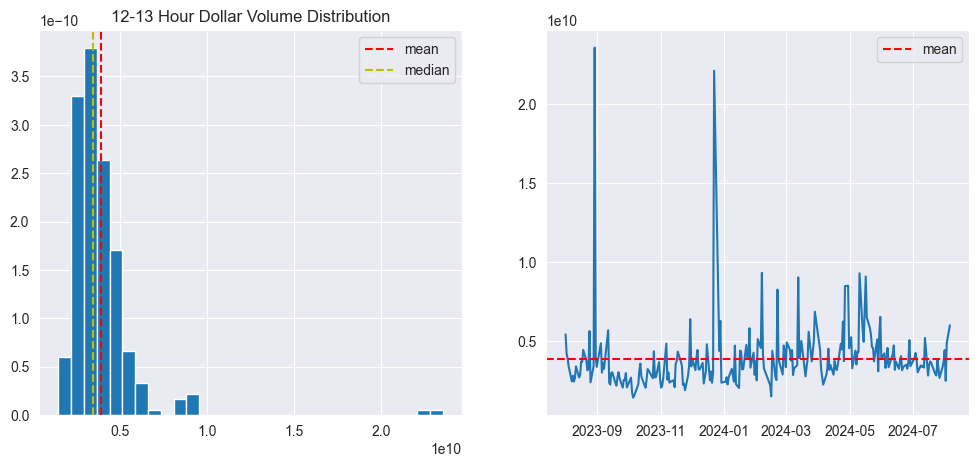

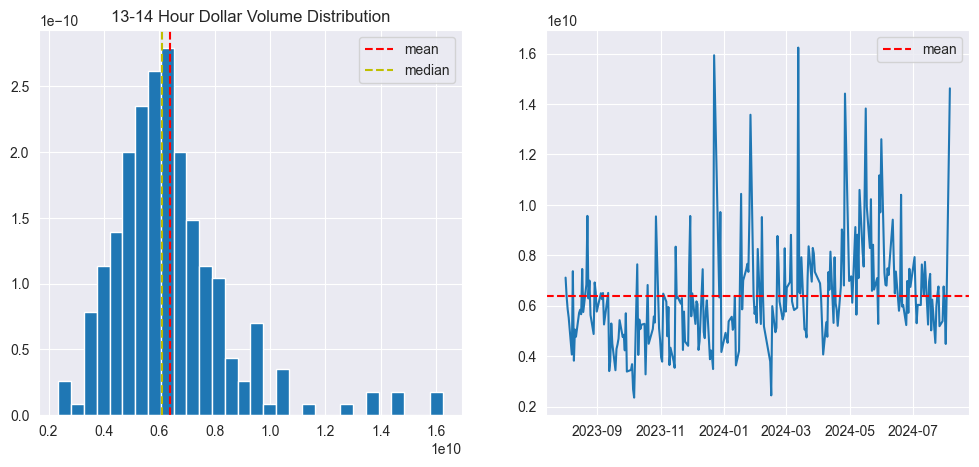

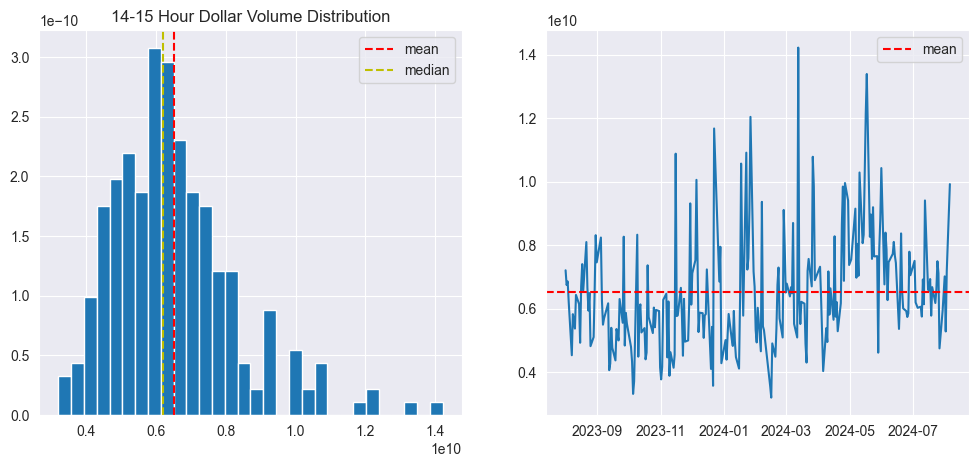

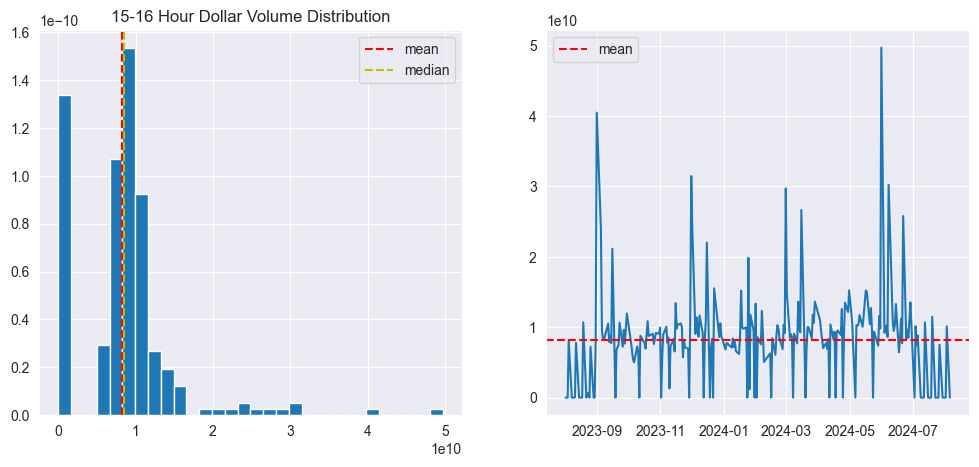

In [7]:
for x in dollar_volumes['dollar_vol'].groupby(dollar_volumes.index.hour):
    temp_df = x[1]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f'{x[0]}-{x[0] + 1} Hour Dollar Volume Distribution')
    
    plt.hist(temp_df.values.tolist(), bins=30, density=True)
    plt.axvline(x=temp_df.mean(), color='r', linestyle='--', label='mean')
    plt.axvline(x=temp_df.median(), color='y', linestyle='--', label='median')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(temp_df)
    plt.axhline(temp_df.mean(), label='mean', color='r', linestyle='--')
    plt.legend()

    plt.show()

Conclusion:
- Lots of zeros in the data, especially during the opening and ending hours. These data might be incorrect
- Try to remove zeros and look at the distribution

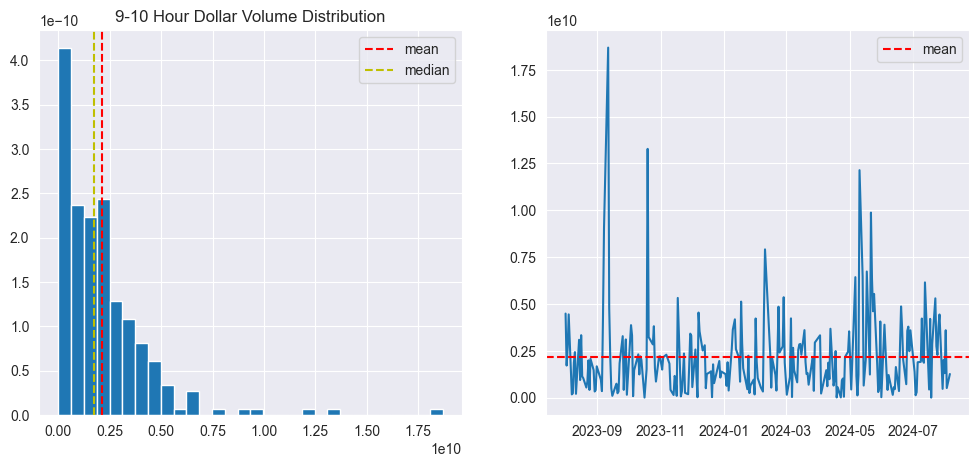

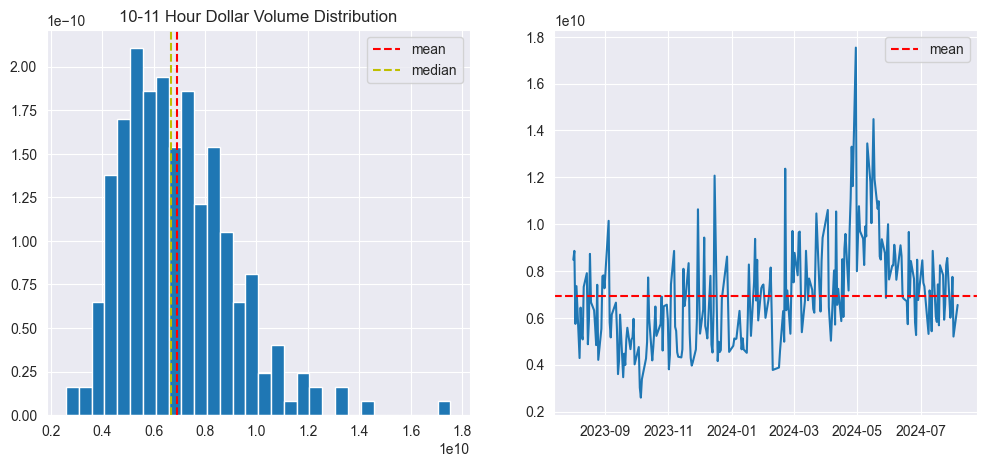

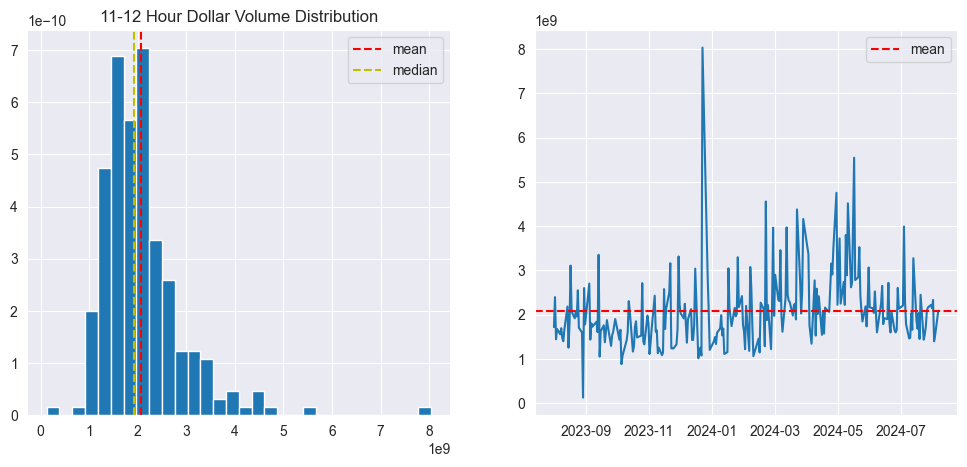

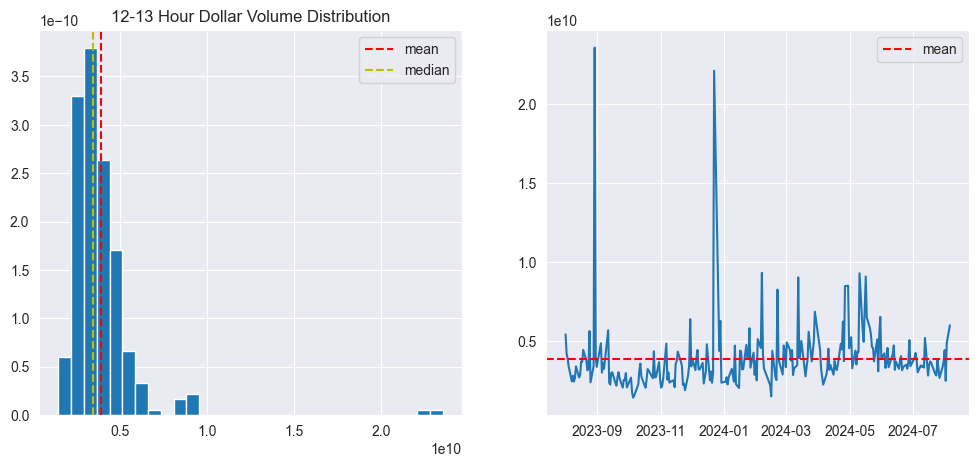

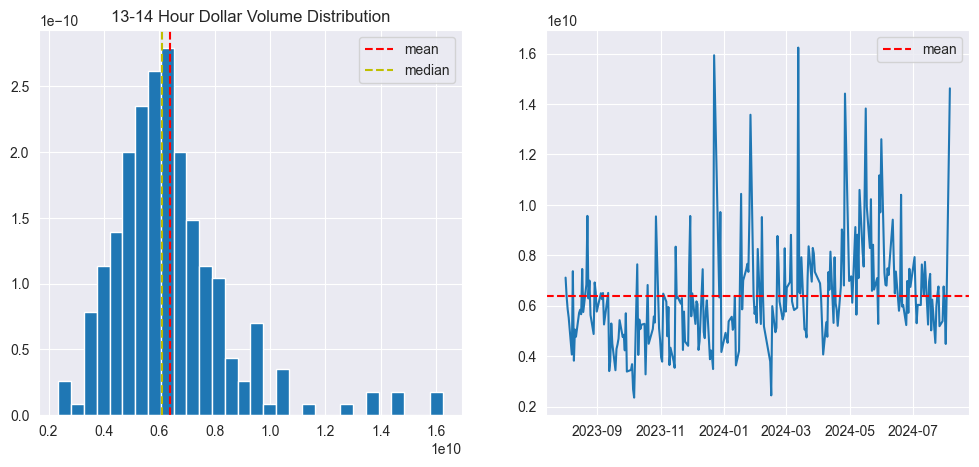

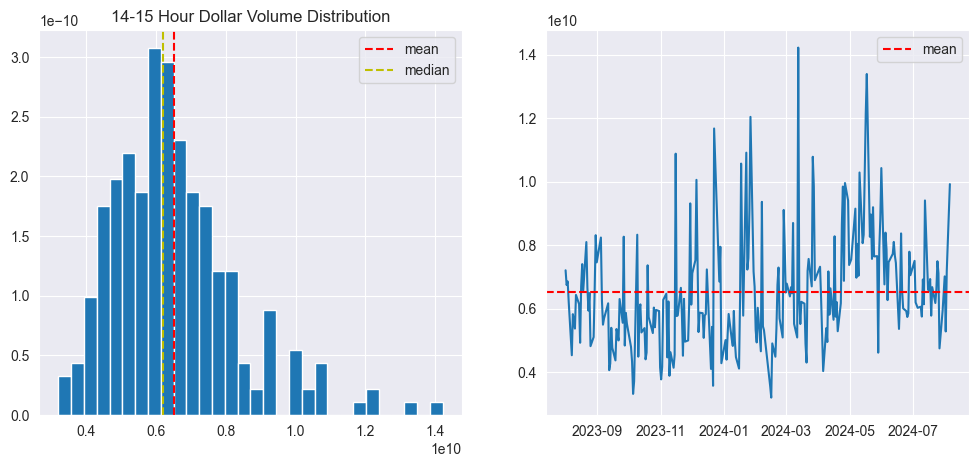

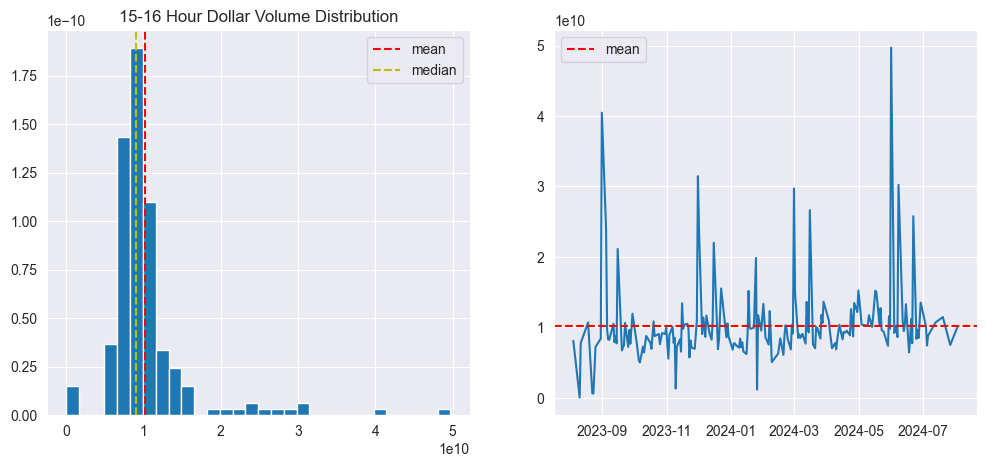

In [8]:
for x in dollar_volumes['dollar_vol'].groupby(dollar_volumes.index.hour):
    temp_df = x[1][x[1] != 0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f'{x[0]}-{x[0] + 1} Hour Dollar Volume Distribution')
    
    plt.hist(temp_df.values.tolist(), bins=30, density=True)
    plt.axvline(x=temp_df.mean(), color='r', linestyle='--', label='mean')
    plt.axvline(x=temp_df.median(), color='y', linestyle='--', label='median')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(temp_df)
    plt.axhline(temp_df.mean(), label='mean', color='r', linestyle='--')
    plt.legend()

    plt.show()

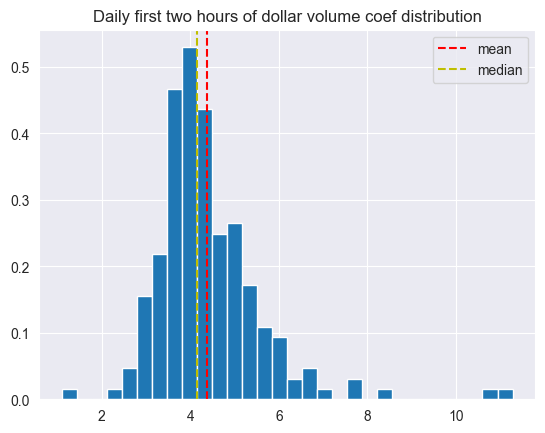

Mean coef: 4.386842605092496, Std: 1.2222317818050803
Skewness: 2.0482230279743474, Kurtosis: 8.576075396817851
Jarque-Bera test p-value: 2.5486536114923734e-147
p_value < 0.05, the distribution is likely not normal


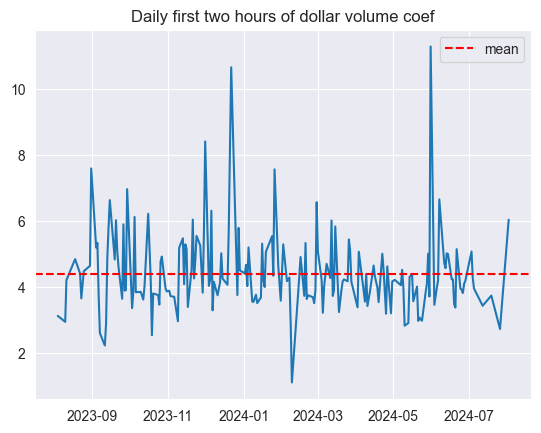

Dickey-Fuller test p-value: 3.2332182909794165e-23
p_value < 0.05, the data is likely to be stationary


In [9]:
zero_dates = dollar_vol_df[dollar_vol_df['dollar_vol'] == 0]['date_str']
dollar_vol_df = dollar_vol_df[~dollar_vol_df['date_str'].isin(zero_dates)]

two_hour_df = dollar_vol_df[['dollar_vol', 'day_dollar_vol']][dollar_vol_df.index.hour < 11].resample('D').sum()
x = (two_hour_df['day_dollar_vol'] / two_hour_df['dollar_vol'] / 2).dropna()
plt.hist(x, bins=30, density=True)
plt.axvline(x = x.mean(), color='r', linestyle='--', label='mean')
plt.axvline(x = x.median(), color='y', linestyle='--', label='median')
plt.title('Daily first two hours of dollar volume coef distribution')
plt.legend()
plt.show()

print(f'Mean coef: {x.mean()}, Std: {x.std()}')
print(f'Skewness: {x.skew()}, Kurtosis: {x.kurtosis()}')
test_stats, p_value = stats.jarque_bera(x)
print(f'Jarque-Bera test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the distribution is likely not normal')
else:
    print('p_value >= 0.05, the distribution is likely to be normal')

plt.title('Daily first two hours of dollar volume coef')
plt.plot(x)
plt.axhline(x.mean(), label='mean', color='r', linestyle='--')
plt.legend()
plt.show()

tup = adfuller(x)
test_stats, p_value = tup[0], tup[1]
print(f'Dickey-Fuller test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the data is likely to be stationary')
else:
    print('p_value >= 0.05, the data is likely to be non-stationary')

[*********************100%%**********************]  1 of 1 completed

Dickey-Fuller test p-value: 1.5229589745048409e-06
p_value < 0.05, the data is likely to be stationary


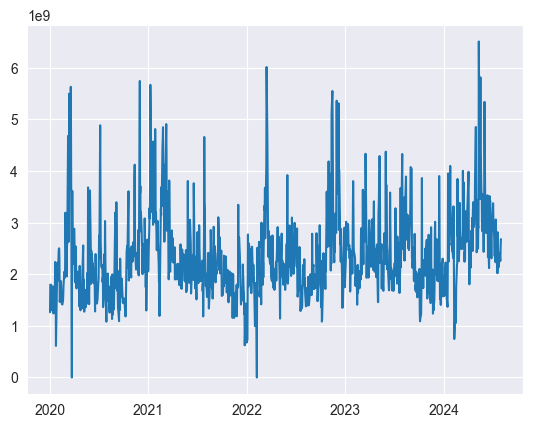

In [10]:
hsi = yf.download('^HSI', start='2020-01-01', end='2024-08-01')
tup = adfuller(hsi['Volume'])
test_stats, p_value = tup[0], tup[1]
plt.plot(hsi['Volume'])
print(f'Dickey-Fuller test p-value: {p_value}')
if p_value < 0.05:
    print('p_value < 0.05, the data is likely to be stationary')
else:
    print('p_value >= 0.05, the data is likely to be non-stationary')

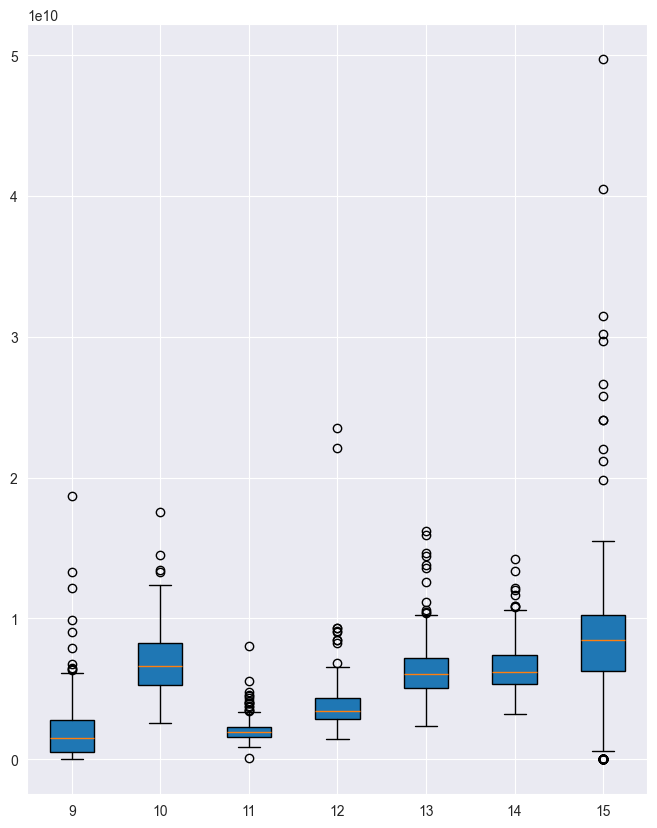

In [11]:
intraday_df = dict()
intraday_dfs = dollar_volumes['dollar_vol'].groupby(dollar_volumes.index.hour)
values = []
names = []
for _df in intraday_dfs:
    values.append(_df[1].values.tolist())
    names.append(_df[0])

fig, ax = plt.subplots(figsize=(8, 10))

bplot = ax.boxplot(values, patch_artist=True, tick_labels=names) 

plt.show()